In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import random
import os
from os import listdir
from PIL import Image
import tensorflow as tf
from keras.preprocessing import image
from tensorflow. keras.utils import img_to_array, array_to_img
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from sklearn. model_selection import train_test_split
from keras.models import model_from_json
from keras.utils import to_categorical



In [2]:
dataset = tf.keras.utils.image_dataset_from_directory(
    r"C:\Users\fastf\Downloads\soil dataset\Soil Types",
    image_size=(224, 224),
    batch_size=32)





Found 144 files belonging to 6 classes.


**DATA VISUALIZATION**

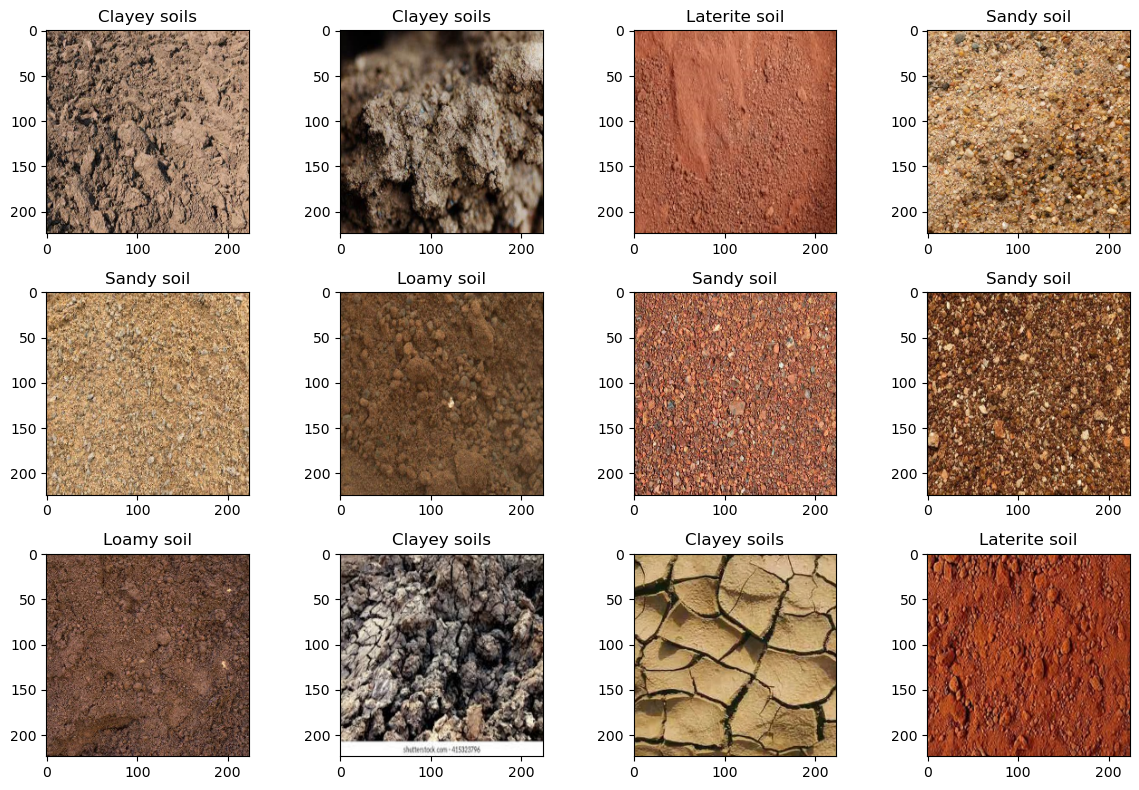

In [3]:
class_names = dataset.class_names

plt.figure(figsize=(12, 8))
for images, labels in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("on")
plt.tight_layout()
plt.show()

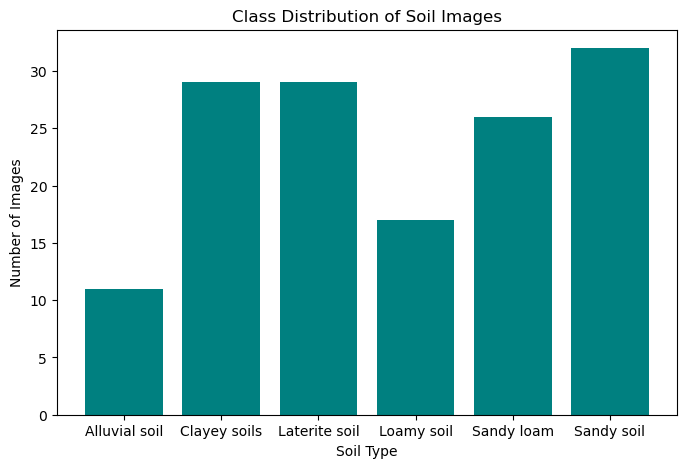

In [4]:
data_dir = r"C:\Users\fastf\Downloads\soil dataset\Soil Types"
classes = os.listdir(data_dir)
counts = [len(os.listdir(os.path.join(data_dir, cls))) for cls in classes]

plt.figure(figsize=(8,5))
plt.bar(classes, counts, color='teal')
plt.xlabel("Soil Type")
plt.ylabel("Number of Images")
plt.title("Class Distribution of Soil Images")
plt.show()


**DATA AGUMENTATION**

In [5]:
from tensorflow.keras import layers
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

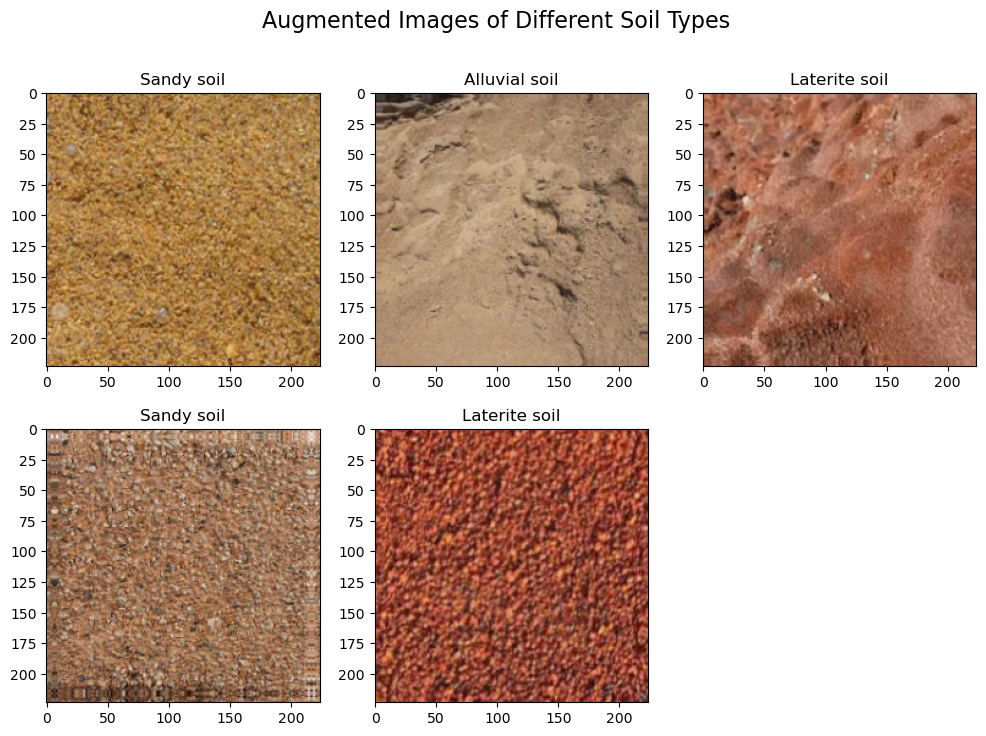

In [6]:
plt.figure(figsize=(12, 8))


count = 0
for images, labels in dataset.shuffle(1000).take(6):  
    augmented_img = data_augmentation(images)
    ax = plt.subplot(2, 3, count + 1)
    
    plt.imshow(augmented_img[0].numpy().astype("uint8"))
    plt.axis("on")
    
    
    label_name = class_names[labels[0].numpy()]
    ax.set_title(label_name, fontsize=12, color="black")
    
    count += 1

plt.suptitle("Augmented Images of Different Soil Types", fontsize=16)
plt.show()


In [54]:
import os
import glob
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array


datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

input_dir = r"C:\Users\fastf\Downloads\soil dataset\Soil Types"
output_dir = r"C:\Users\fastf\Downloads\soil dataset\Soil Types_Augmented"
os.makedirs(output_dir, exist_ok=True)

num_augmented = 5  # per original image

for class_folder in os.listdir(input_dir):
    class_path = os.path.join(input_dir, class_folder)
    save_class_path = os.path.join(output_dir, class_folder)
    os.makedirs(save_class_path, exist_ok=True)

    # Collect all image paths with common extensions
    image_paths = glob.glob(f"{class_path}/*.jpg") + glob.glob(f"{class_path}/*.jpeg") + glob.glob(f"{class_path}/*.png")

    print(f"{class_folder}: {len(image_paths)} original images found")

    for img_path in image_paths:
        img = image.load_img(img_path, target_size=(150, 150))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)

        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=save_class_path,
                                  save_prefix='soil', save_format='jpg'):
            i += 1
            if i >= num_augmented:
                break

print("Augmentation done!")



Alluvial soil: 11 original images found
Clayey soils: 29 original images found
Laterite soil: 29 original images found
Loamy soil: 17 original images found
Sandy loam: 26 original images found
Sandy soil: 32 original images found
Augmentation done!


In [55]:
for class_folder in os.listdir(output_dir):
    class_path = os.path.join(output_dir, class_folder)
    print(f"{class_folder}: {len(os.listdir(class_path))} images")



Alluvial soil: 55 images
Clayey soils: 144 images
Laterite soil: 145 images
Loamy soil: 97 images
Sandy loam: 126 images
Sandy soil: 159 images


In [56]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  
)

train_generator = train_datagen.flow_from_directory(
    output_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    output_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

   

Found 583 images belonging to 6 classes.
Found 143 images belonging to 6 classes.


**LOAD PRETRAINED MODEL**


In [73]:
from tensorflow.keras.applications import MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))
base_model.trainable = False

C:\Users\fastf\AppData\Local\Temp\ipykernel_14804\269398293.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))


In [74]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [77]:
model.compile(optimizer=Adam(learning_rate=5e-5), loss='categorical_crossentropy', metrics=['accuracy'])


In [91]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
]
classes = np.unique(train_generator.classes)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_generator.classes)
class_weights = dict(zip(classes, weights))

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights, 
    callbacks=callbacks
)


Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 476ms/step - accuracy: 0.9962 - loss: 0.0302 - val_accuracy: 1.0000 - val_loss: 0.0048 - learning_rate: 1.0000e-05
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 471ms/step - accuracy: 0.9990 - loss: 0.0228 - val_accuracy: 1.0000 - val_loss: 0.0056 - learning_rate: 1.0000e-05
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 499ms/step - accuracy: 0.9968 - loss: 0.0289 - val_accuracy: 1.0000 - val_loss: 0.0064 - learning_rate: 1.0000e-05
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 509ms/step - accuracy: 0.9972 - loss: 0.0282 - val_accuracy: 1.0000 - val_loss: 0.0066 - learning_rate: 1.0000e-05
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 488ms/step - accuracy: 0.9844 - loss: 0.0408 - val_accuracy: 1.0000 - val_loss: 0.0060 - learning_rate: 2.0000e-06
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 466ms/step - accuracy: 0.9964 - loss: 0.0271 - val_accuracy: 1.0000 - val_loss: 0.0055 - learning_rate: 2.0000e-06


**FINE TUNING (unfreeze last layer)**

In [92]:
base_model.trainable = True
for layer in base_model.layers[:50]:  # freeze early layers
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=5e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [93]:
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 34s 608ms/step - accuracy: 0.9922 - loss: 0.0360 - val_accuracy: 1.0000 - val_loss: 0.0080 - learning_rate: 5.0000e-05
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 445ms/step - accuracy: 0.9929 - loss: 0.0252 - val_accuracy: 1.0000 - val_loss: 0.0048 - learning_rate: 5.0000e-05
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 466ms/step - accuracy: 0.9985 - loss: 0.0250 - val_accuracy: 1.0000 - val_loss: 0.0045 - learning_rate: 5.0000e-05
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 468ms/step - accuracy: 1.0000 - loss: 0.0105 - val_accuracy: 1.0000 - val_loss: 0.0077 - learning_rate: 5.0000e-05
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 423ms/step - accuracy: 0.9948 - loss: 0.0201 - val_accuracy: 1.0000 - val_loss: 0.0129 - learning_rate: 5.0000e-05
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 447ms/step - accuracy: 1.0000 - loss: 0.0134 - val_accuracy: 1.0000 - val_loss: 0.0090 - learning_rate: 5.0000e-05
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 469ms/step - accuracy:

In [94]:
model.save("soil_classification_model.h5")
print("Model saved as soil_classification_model.h5")




Model saved as soil_classification_model.h5


In [95]:
loss, acc = model.evaluate(validation_generator)
print(f"Final Validation Accuracy: {acc:.4f}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 276ms/step - accuracy: 0.4576 - loss: 2.0130
Final Validation Accuracy: 0.6584


**MODEL VISUALIZATION**

23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 355ms/step


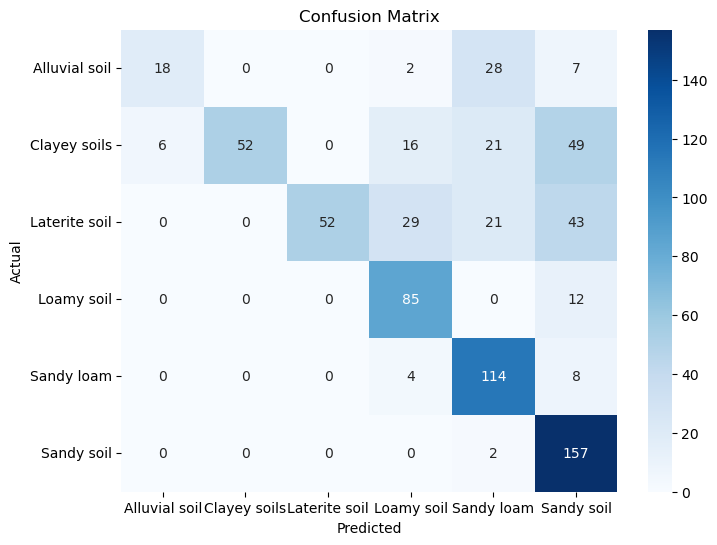

In [96]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=validation_generator.class_indices.keys(),
            yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [97]:
target_names = list(validation_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names))

               precision    recall  f1-score   support

Alluvial soil       0.75      0.33      0.46        55
 Clayey soils       1.00      0.36      0.53       144
Laterite soil       1.00      0.36      0.53       145
   Loamy soil       0.62      0.88      0.73        97
   Sandy loam       0.61      0.90      0.73       126
   Sandy soil       0.57      0.99      0.72       159

     accuracy                           0.66       726
    macro avg       0.76      0.64      0.62       726
 weighted avg       0.77      0.66      0.63       726



**LOAD THE TRAINED MODEL**

In [99]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("soil_classification_model.h5")


**PREDICTION ON NEW IMAGES**

In [111]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess the image
img_path = r"C:\Users\fastf\Downloads\soil dataset\Soil Types\Clayey soils\clay 9.png"
img_path = r"C:\Users\fastf\Downloads\soil dataset\Soil Types\Laterite soil\laterite 9.png"

img = image.load_img(img_path, target_size=(150, 150)) 
x = image.img_to_array(img)
x = x / 255.0  
x = np.expand_dims(x, axis=0)  


In [112]:
pred = model.predict(x)
pred_class = np.argmax(pred)  
confidence = pred[0][pred_class]  

print(f"Predicted Soil Type: {class_labels[pred_class]}")
print(f"Confidence: {confidence:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Soil Type: Laterite soil
Confidence: 0.82


In [113]:
img_path = r"C:\Users\fastf\Downloads\soil dataset\Soil Types\Clayey soils\clay 9.png"

img = image.load_img(img_path, target_size=(150, 150)) 
x = image.img_to_array(img)
x = x / 255.0  
x = np.expand_dims(x, axis=0)  


In [114]:
pred = model.predict(x)
pred_class = np.argmax(pred)  
confidence = pred[0][pred_class]  

print(f"Predicted Soil Type: {class_labels[pred_class]}")
print(f"Confidence: {confidence:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Predicted Soil Type: Clayey soils
Confidence: 0.99
